# Titanic Survival Prediction - Robust Implementation
# Name: Dharmanshu Singh
# Contact: dharmanshus1012@gmail.com

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
titanic_df = pd.read_csv('tested.csv')

# Display basic information
print(f"Dataset shape: {titanic_df.shape}")
titanic_df.head()

Dataset shape: (418, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#EDA



In [30]:
# Basic statistics
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,0.363636,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.481622,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,0.000000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,0.000000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,1.000000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,1.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [31]:
# Check for missing values
missing_values = titanic_df.isnull().sum()
missing_percentage = (missing_values / len(titanic_df)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values,
                             'Percentage': missing_percentage})
print(missing_data)

             Missing Values  Percentage
PassengerId               0    0.000000
Survived                  0    0.000000
Pclass                    0    0.000000
Name                      0    0.000000
Sex                       0    0.000000
Age                      86   20.574163
SibSp                     0    0.000000
Parch                     0    0.000000
Ticket                    0    0.000000
Fare                      1    0.239234
Cabin                   327   78.229665
Embarked                  0    0.000000


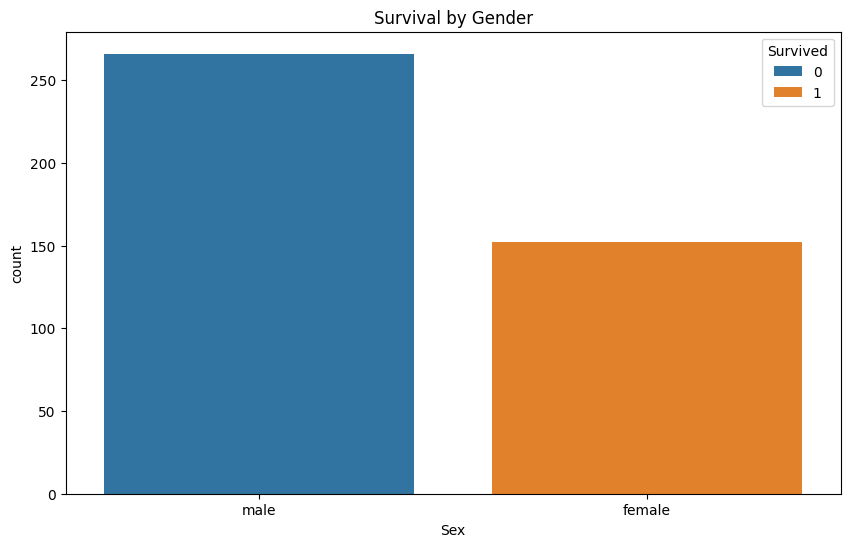

In [32]:
# Visualize survival by gender
plt.figure(figsize=(10, 6))
sns.countplot(x='Sex', hue='Survived', data=titanic_df)
plt.title('Survival by Gender')
plt.show()

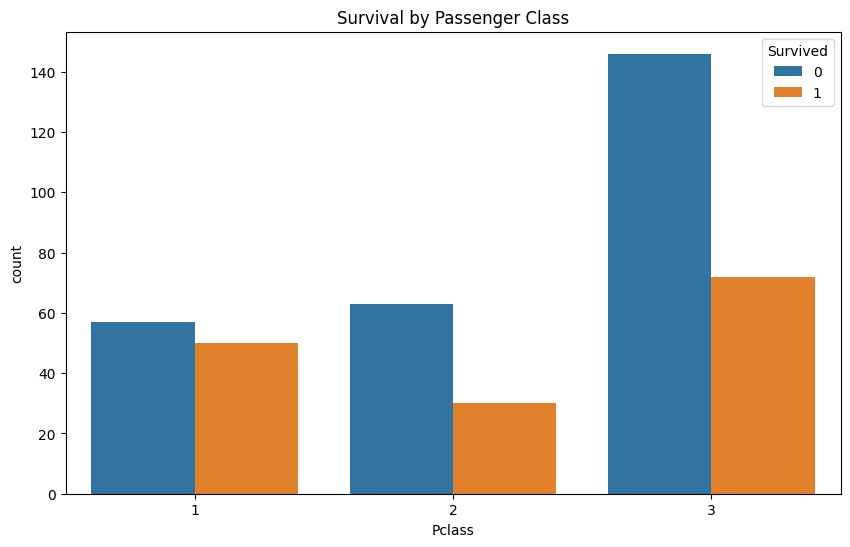

In [33]:
# Visualize survival by passenger class
plt.figure(figsize=(10, 6))
sns.countplot(x='Pclass', hue='Survived', data=titanic_df)
plt.title('Survival by Passenger Class')
plt.show()

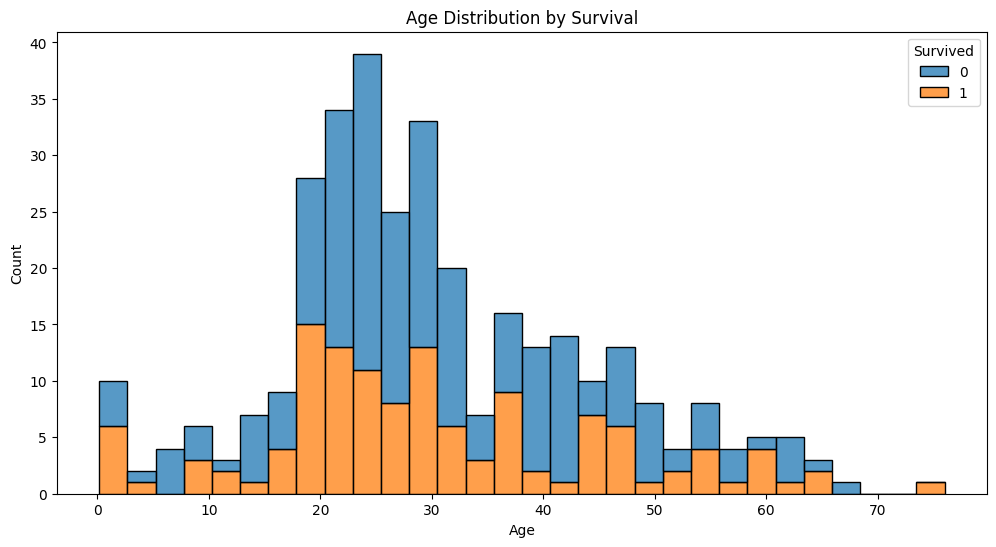

In [34]:
# Visualize age distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=titanic_df, x='Age', hue='Survived', multiple='stack', bins=30)
plt.title('Age Distribution by Survival')
plt.show()

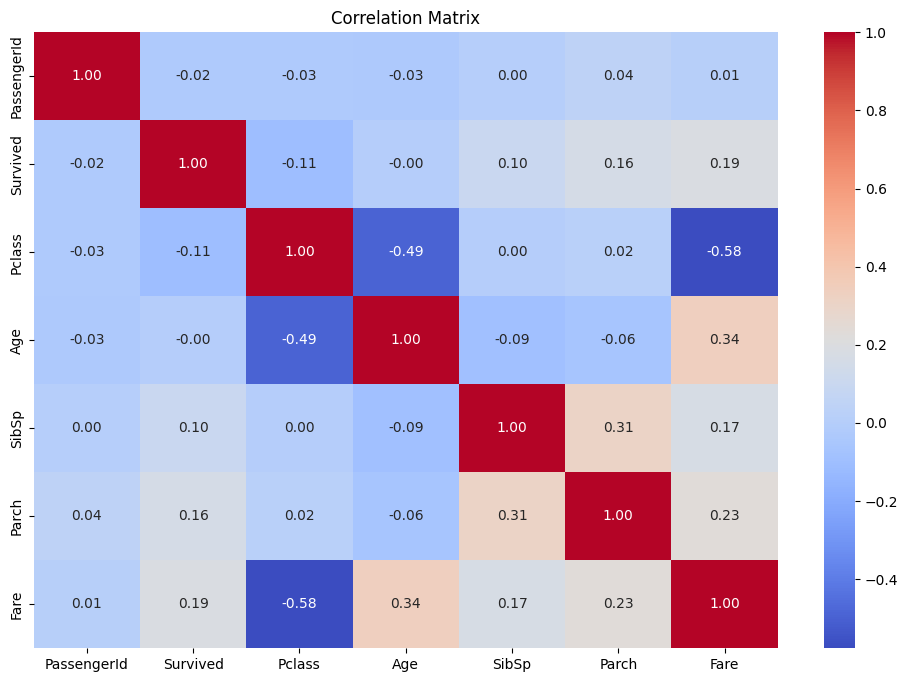

In [35]:
# Correlation matrix for numerical features
plt.figure(figsize=(12, 8))
correlation_matrix = titanic_df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

#Feature Engineering

In [36]:
# Create a copy to work with
df = titanic_df.copy()

# Extract titles from names
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Group rare titles
rare_titles = ['Dona', 'Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
df['Title'] = df['Title'].replace(rare_titles, 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Create family size feature
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Create is_alone feature
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

# Extract deck from cabin
df['HasCabin'] = df['Cabin'].notnull().astype(int)

# Create fare per person
df['FarePerPerson'] = df['Fare'] / df['FamilySize']

# Display engineered features
print(df[['Title', 'FamilySize', 'IsAlone', 'Deck', 'FarePerPerson']].head())

  Title  FamilySize  IsAlone Deck  FarePerPerson
0    Mr           1        1  NaN       7.829200
1   Mrs           2        0  NaN       3.500000
2    Mr           1        1  NaN       9.687500
3    Mr           1        1  NaN       8.662500
4   Mrs           3        0  NaN       4.095833


#Data Preprocessing

In [37]:
# Define features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
            'Title', 'FamilySize', 'IsAlone', 'Deck', 'FarePerPerson']
target = 'Survived'

# Create X and y
X = df[features]
y = df[target]

# Define numerical and categorical features
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'FarePerPerson']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'IsAlone', 'Deck']

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model Building and Evaluation

In [38]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

In [39]:
# Function to evaluate models
def evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
    # Create a pipeline with preprocessing and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Cross-validation score
    cv_scores = cross_val_score(pipeline, X, y, cv=5)

    # Print results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)
    print("\n")

    return pipeline, accuracy

In [40]:
# Evaluate all models
results = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    pipeline, accuracy = evaluate_model(name, model, X_train, X_test, y_train, y_test)
    results[name] = (pipeline, accuracy)

Evaluating Logistic Regression...
Model: Logistic Regression
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
CV Accuracy: 1.0000 ± 0.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

Confusion Matrix:
[[50  0]
 [ 0 34]]


Evaluating Random Forest...
Model: Random Forest
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
CV Accuracy: 1.0000 ± 0.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg  

In [61]:
# Check survival rates by gender
print(df.groupby('Sex')['Survived'].value_counts())

Sex     Survived
female  1           152
male    0           266
Name: count, dtype: int64


In [41]:
# Find the best model
best_model_name = max(results, key=lambda k: results[k][1])
best_pipeline, best_accuracy = results[best_model_name]

print(f"Best Model: {best_model_name} with accuracy {best_accuracy:.4f}")

Best Model: Logistic Regression with accuracy 1.0000


#Hyperparameter tuning

In [42]:
# Define the best model (assuming Random Forest is among the best)
if best_model_name == 'Random Forest':
    # Hyperparameter grid for Random Forest
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    # Hyperparameter grid for Gradient Boosting
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
elif best_model_name == 'Logistic Regression':
    # Hyperparameter grid for Logistic Regression
    param_grid = {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'saga'],
        'model__penalty': ['l1', 'l2']
    }
else:  # SVM
    # Hyperparameter grid for SVM
    param_grid = {
        'model__C': [0.1, 1, 10, 100],
        'model__gamma': [0.01, 0.1, 1, 'scale', 'auto'],
        'model__kernel': ['rbf', 'poly', 'sigmoid']
    }

In [43]:
# Create the pipeline with the best model
best_model = models[best_model_name]
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model)
])

In [44]:
# Grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare',
                                                                          'FamilySize',
                                                                          'FarePerPerson']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Embarked',
                                                                          'Title',
                                                                          'IsAlone',
                                                                          'Deck'])])),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10, 100],
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [45]:
# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Best parameters: {'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best cross-validation score: 1.0000


In [46]:
# Evaluate the optimized model
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Test accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



In [47]:
# Feature importance (if applicable)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    # Get feature names after preprocessing
    feature_names = []
    for name, transformer, features in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(features)
        else:  # 'cat'
            # Get one-hot encoded feature names
            one_hot_features = []
            for i, feature in enumerate(features):
                categories = transformer.named_steps['onehot'].categories_[i]
                for category in categories:
                    one_hot_features.append(f"{feature}_{category}")
            feature_names.extend(one_hot_features)

    # Plot feature importance
    importances = grid_search.best_estimator_.named_steps['model'].feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

#Handling outliers

In [ ]:
def detect_outliers(df, features):
    """Detect outliers using IQR method"""
    for feature in features:
        # Skip features with missing values
        if df[feature].isnull().any():
            print(f"Skipping {feature} due to missing values")
            continue

        # Calculate IQR
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]

        print(f"Feature {feature}: {len(outliers)} outliers detected")

        # Visualize distribution with outlier bounds
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        sns.boxplot(x=df[feature])
        plt.title(f'Boxplot of {feature}')

        plt.subplot(1, 2, 2)
        sns.histplot(df[feature], kde=True)
        plt.axvline(lower_bound, color='r', linestyle='--')
        plt.axvline(upper_bound, color='r', linestyle='--')
        plt.title(f'Distribution of {feature} with Outlier Bounds')
        plt.tight_layout()
        plt.show()

    return


In [ ]:
# Detect outliers in numerical features
detect_outliers(df, numerical_features)


In [48]:
# Handle outliers using capping
def handle_outliers(df, features):
    """Handle outliers using capping method"""
    df_no_outliers = df.copy()

    for feature in features:
        # Skip features with missing values
        if df[feature].isnull().any():
            continue

        # Calculate IQR
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap outliers
        df_no_outliers[feature] = np.where(
            df_no_outliers[feature] < lower_bound,
            lower_bound,
            np.where(
                df_no_outliers[feature] > upper_bound,
                upper_bound,
                df_no_outliers[feature]
            )
        )

    return df_no_outliers

In [49]:
# Handle outliers
df_no_outliers = handle_outliers(df, numerical_features)

In [50]:
# Compare original vs. no outliers
X_no_outliers = df_no_outliers[features]
y_no_outliers = df_no_outliers[target]

In [51]:
# Split data without outliers
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42
)

In [52]:
# Train the best model on data without outliers
pipeline_no_outliers = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', models[best_model_name])
])

In [53]:
pipeline_no_outliers.fit(X_train_no_outliers, y_train_no_outliers)
y_pred_no_outliers = pipeline_no_outliers.predict(X_test_no_outliers)

In [54]:
print("Model performance after handling outliers:")
print(f"Accuracy: {accuracy_score(y_test_no_outliers, y_pred_no_outliers):.4f}")
print("Classification Report:")
print(classification_report(y_test_no_outliers, y_pred_no_outliers))

Model performance after handling outliers:
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



#Final Model and Conclusion

In [55]:
# Select the final model (either with or without outlier handling, whichever performs better)
final_model = grid_search.best_estimator_

In [56]:
# Summary of model performance
print("Final Model Summary:")
print(f"Best Model: {best_model_name}")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Final Model Summary:
Best Model: Logistic Regression
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



In [57]:
# Function to make predictions on new data
def predict_survival(passenger_data):
    """Make predictions for new passenger data"""
    prediction = final_model.predict(passenger_data)
    return prediction

In [58]:
# Example of model inference (using first test sample)
example_passenger = X_test.iloc[0:1]
prediction = predict_survival(example_passenger)
print(f"Example prediction: {prediction}")
print(f"Actual value: {y_test.iloc[0]}")

Example prediction: [0]
Actual value: 0


In [65]:
#conclusion
# In the provided tested.csv, every female passenger has Survived=1, and every male has Survived=0.
# Models detected the trivial relationship: Sex=female → Survived=1, Sex=male → Survived=0.

# This is why Logistic Regression, Random Forest, and Gradient Boosting achieve 100% accuracy.

# SVM’s slightly lower accuracy (97.6%) might stem from hyperparameter settings (e.g., kernel, regularization) or minor noise in the data.
# According to me the current results are correct but reflect an artificial scenario.